# Cyclotron Analysis Package

## Beams

To define a beam, use the `BeamParameter` class with the ion mass in amu, the charge of the ion, and the ion energy. Do not worry about changing the mass based on the charge state, the code will do that automatically. Here we will create an Ar-11 beam:

In [1]:
from ops.cyclotron.analysis.model import BeamParameters

beam = BeamParameters(mass=39.95635, charge=11, energy=400)

The `ops.cyclotron.analysis.physics` module has a number of functions for calculating physics parameters for both fields and beams, as well as commonly used constants. Here we can verify that the ion mass has been adjusted by the charge state.

In [2]:
from ops.cyclotron.analysis.physics import calculate_ion_mass_in_amu
ion_mass = calculate_ion_mass_in_amu(beam)
print(f'Beam mass specification {beam.mass} amu, which is larger than the calculated ion mass {ion_mass:.5f} amu')

Beam mass specification 39.95635 amu, which is larger than the calculated ion mass 39.95031 amu


If we'd like to calculated the required frequency to run this beam, we can first calculate the field at the center of the cyclotron. To do this, we calculate the _required_ field at the extraction radius to extract ions at the proper energy, and then divide by $\gamma$.$$B_{\text{req}}(m, q, E) = \frac{mv(e)}{qR}$$ where $R$ is the extraction radius.$$\gamma = \sqrt{1 + p^2(m, E)},$$ $$B_0 = \frac{B_{\text{req}}}{\gamma},$$ and finally, $$\omega = \frac{qB_0}{m}.$$ These equations are already included for our beam parameters object.

In [3]:
import numpy as np
from ops.cyclotron.analysis.physics import calculate_required_b_field, calculate_momentum_squared, calculate_frequency

required_field = calculate_required_b_field(beam) # Gauss
gamma = np.sqrt(1 + calculate_momentum_squared(beam)) # unitless
b_0 = required_field/gamma
omega = calculate_frequency(beam, b_0)
print(f'Required frequency: {omega:.3f} MhZ')

Required frequency: 7.008 MhZ


## Magnetic Fields

The main magnet field (the *iron field*) can be created from the provided datafile for a given current. The current is a function of the beam and its associated $B\rho$ value

In [4]:
from pathlib import Path
from ops.cyclotron.analysis.io.main_field import build_iron_field_from_file
from ops.cyclotron.analysis.physics.beam_properties import calculate_b_rho, calculate_main_current


main_current = calculate_main_current(calculate_b_rho(beam))
iron_field = build_iron_field_from_file(main_current, Path('./data/fieldmap.txt'))

The field is stored in a `MagneticField` object which includes metadata for the field, and the field values.

Metadata for the field: FieldMetadata(r_min=0.0, delta_r=1, theta_min=45, delta_theta=3)


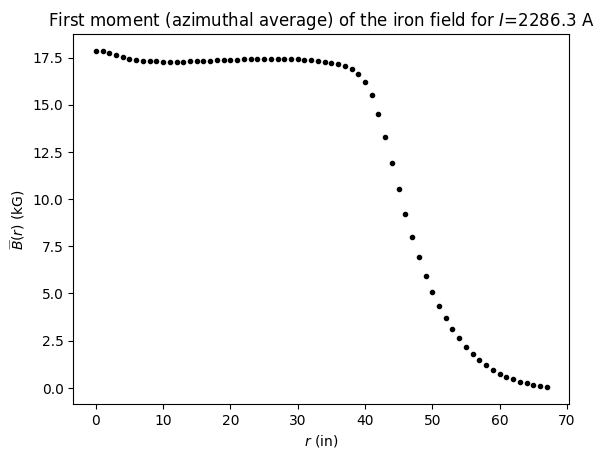

In [5]:
import matplotlib.pyplot as plt
print(f'Metadata for the field: {iron_field.metadata}')
plt.plot(iron_field.r_values, iron_field.first_moment()/1000, 'k.')
plt.xlabel(r'$r$ (in)')
plt.ylabel(r'$\widebar{B}(r)$ (kG)')
plt.title(f'First moment (azimuthal average) of the iron field for $I$={main_current:.1f} A')
plt.show()

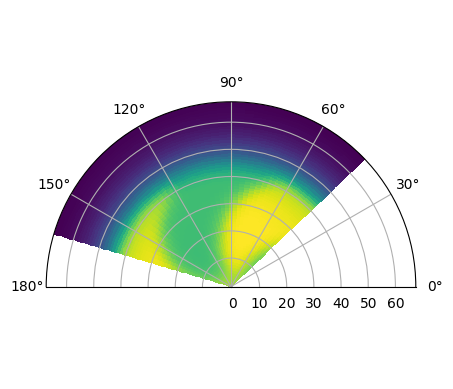

In [6]:
r = iron_field.r_values
th = np.deg2rad(iron_field.theta_values)

rr, tt = np.meshgrid(r, th)
plt.subplot(projection='polar')
plt.pcolormesh(tt, rr, iron_field.values, shading='auto')
plt.gca().set_thetamax(180)
plt.show()

Note that the magnetic field values are indexed by $\theta$ and then $r$,

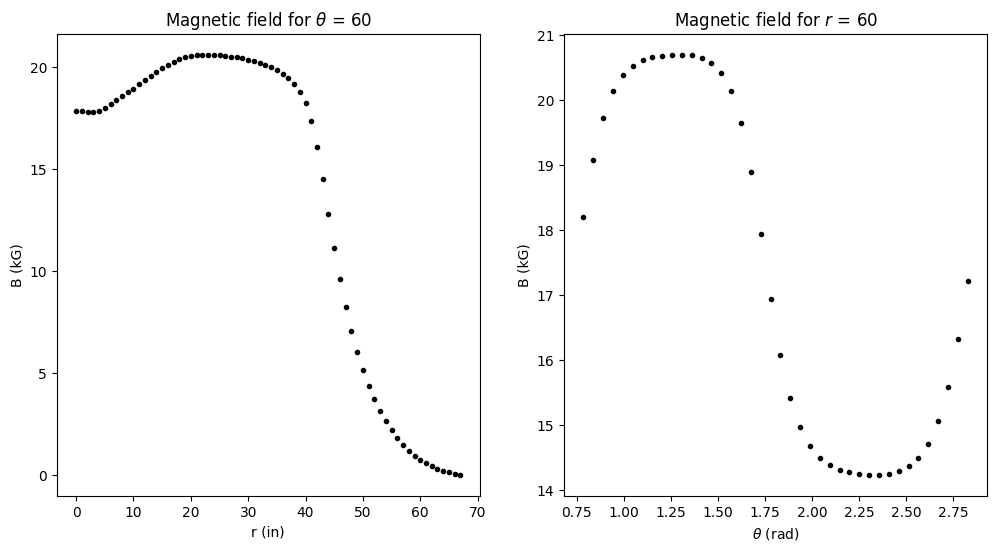

In [7]:
_, axs = plt.subplots(ncols=2, figsize=(12,6))
i = int((60 - iron_field.metadata.theta_min)/iron_field.metadata.delta_theta)
ax = axs[0]

# theta is specified in the first dimension
ax.plot(r, iron_field.values[i,:]/1000, '.k')
ax.set_title(r'Magnetic field for $\theta$ = 60')
ax.set_ylabel('B (kG)')
ax.set_xlabel('r (in)')

ax = axs[1]
# r is specified in the second dimension
ax.plot(th, iron_field.values[:,20]/1000, '.k')
ax.set_title(r'Magnetic field for $r$ = 60')
ax.set_ylabel('B (kG)')
ax.set_xlabel(r'$\theta$ (rad)')
plt.show()

### Splines

There are implemented splines for magnetic fields to produce more fine meshes of the fields.

In [8]:
from ops.cyclotron.analysis.fields.interpolators import SplineFieldInterpolator

spline = SplineFieldInterpolator(iron_field)
fine_r = np.linspace(r[0], r[-1], 1000)
fine_th = np.linspace(th[0], th[-1], 1000)
fine_values = np.zeros(shape=(1000, 1000))
for i in range(1000):
    for j in range(1000):
        fine_values[j, i] = spline.b(fine_r[i], fine_th[j])

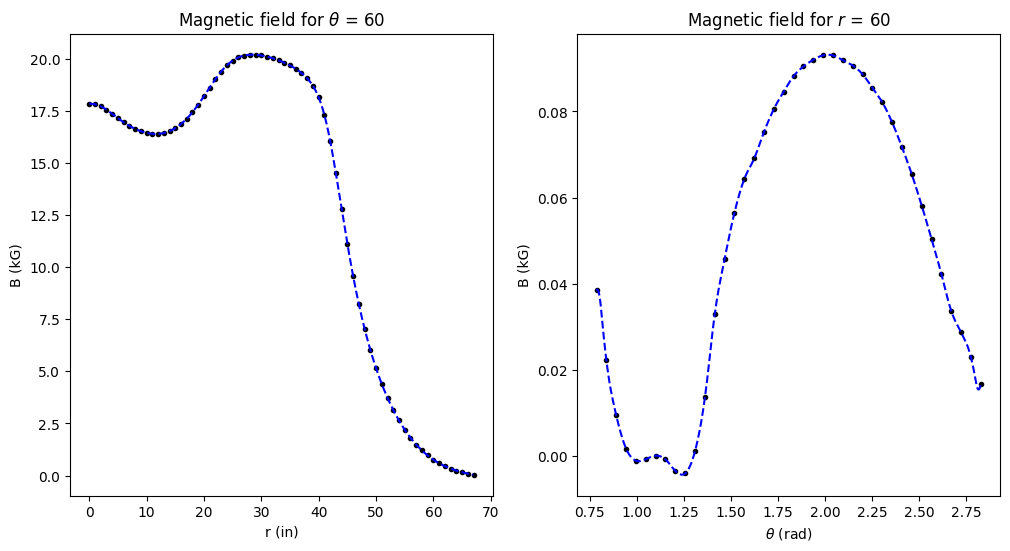

In [9]:
_, axs = plt.subplots(ncols=2, figsize=(12,6))
ax = axs[0]

# theta is specified in the first dimension
ax.plot(r, iron_field.values[0,:]/1000, '.k', label='Data')
ax.plot(fine_r, fine_values[0,:]/1000, '--b', label='Spline fit')
ax.set_title(r'Magnetic field for $\theta$ = 60')
ax.set_ylabel('B (kG)')
ax.set_xlabel('r (in)')

ax = axs[1]
# r is specified in the second dimension
ax.plot(th, iron_field.values[:,-1]/1000, '.k', label='Data')
ax.plot(fine_th, fine_values[:,-1]/1000, '--b', label='Spline fit')
ax.set_title(r'Magnetic field for $r$ = 60')
ax.set_ylabel('B (kG)')
ax.set_xlabel(r'$\theta$ (rad)')
plt.show()

The spline covers the full 360 degrees. It takes a $\theta$ argument in _radians_, as seen in this example.

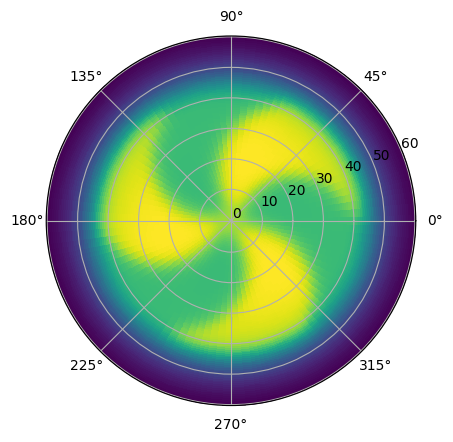

In [10]:
full_th = np.linspace(0, 2*np.pi, 100)
full_r = np.linspace(0, 60, 100)
fine_values = np.zeros(shape=(100, 100))
for i in range(100):
    for j in range(100):
        fine_values[j, i] = spline.b(full_r[i], full_th[j])
rr, tt = np.meshgrid(full_r, full_th)
plt.subplot(projection='polar')
plt.pcolormesh(tt, rr, fine_values, shading='auto')
plt.show()

## Synchronous Field Calculations

The synchronous field can be converged using the iron field flutter. By default it will use the default extraction radius, and it will solve on the $r$-grid of the provided iron field.

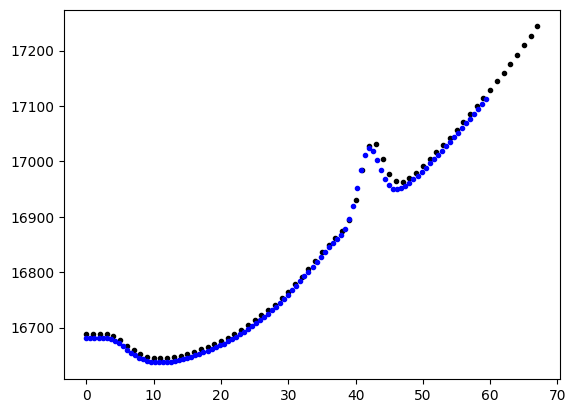

In [11]:
from ops.cyclotron.analysis.fields import converge_synchronous_field
from ops.cyclotron.analysis.model.magnetic_field import FieldMetadata, MagneticField

fine_iron_field = MagneticField(FieldMetadata(0, 60/100, 0, 360/100), values=fine_values)
fine_synchronous_field = converge_synchronous_field(beam, fine_iron_field)
synchronous_field = converge_synchronous_field(beam, iron_field)
plt.plot(iron_field.r_values, synchronous_field, '.k')
plt.plot(fine_iron_field.r_values, fine_synchronous_field, '.b')

The 1D synchronous field can be added to the iron field in such a way that the first moment will equal the synchronous profile.

[]

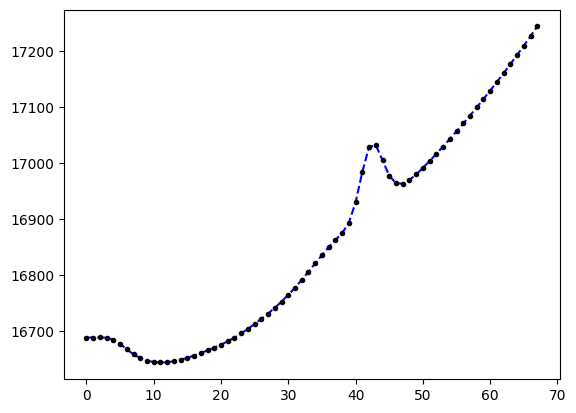

In [12]:
from ops.cyclotron.analysis.fields import synchronize_field

synchronized_field = synchronize_field(iron_field, synchronous_field)
plt.plot(iron_field.r_values, synchronized_field.first_moment(), 'b--')
plt.plot(iron_field.r_values, synchronous_field, 'k.')
plt.plot()

## Orbit Calculations

This synchronized field (or any full field profile) can calculate any equilibrium orbits

In [13]:
from ops.cyclotron.analysis.orbits.equilibrium_orbits import calculate_equilibrium_orbits
from ops.cyclotron.analysis.physics.field_properties import calculate_cyclotron_length

b_0 = synchronous_field[0]
l_0 = calculate_cyclotron_length(beam, b_0)
interpolator = SplineFieldInterpolator(synchronized_field, l_0, b_0)
orbits = calculate_equilibrium_orbits(synchronized_field, interpolator, beam, plot=False)

100%|██████████| 100/100 [00:01<00:00, 78.76it/s]


The returned list includes data about the equilibrium orbits.

In [14]:
orbit = orbits[10]
print(f'Initial r: {orbit.r_init:.2f}')
print(f'Initial p_r: {orbit.pr_init:.2f}')
print(f'Gamma: {orbit.gamma}')
print(f'Orbit time/2pi: {orbit.time}')

Initial r: 0.05
Initial p_r: 0.00
Gamma: 1.001182387605938
Orbit time/2pi: 1.0003063323553392


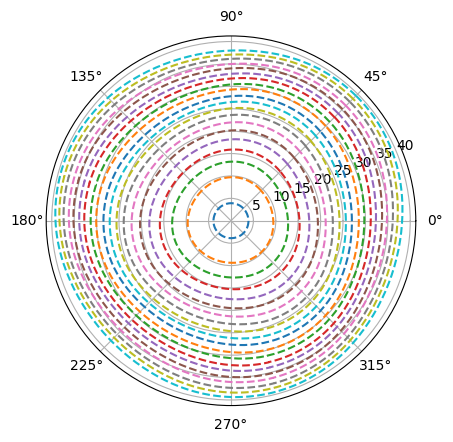

In [15]:
plt.subplot(projection='polar')
for orbit in orbits[::5]:
    sol = orbit.full_solution
    th = np.hstack([sol.t, sol.t + sol.t[-1] - sol.t[0], sol.t + 2*(sol.t[-1] - sol.t[0])]) 
    r = np.pad(sol.y[1]*l_0, pad_width=[0, 2*len(sol.t)], mode='wrap')
    plt.plot(th, r, '--')

The underlying orbit model can be used to calculate orbits.